In [1]:
import numpy as np
import pandas as pd
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import tensorflow as tf
from tensorflow.keras.layers import LSTM, Dense
from sklearn.metrics import mean_squared_error

In [64]:
# load the data from CSV file
x_train = pd.read_csv("input_train.csv")
x_train = np.array(x_train)
y_train = pd.read_csv("output_train.csv")
y_train = np.array(y_train)

x_test = pd.read_csv("input_test.csv")
x_test = np.array(x_test)
y_test = pd.read_csv("output_test.csv")
y_test = np.array(y_test)

In [68]:
x_train

array([[1.0000e+00, 5.0788e-01, 6.6583e-01, ..., 4.2857e-01, 1.0000e+00,
        1.5340e-01],
       [2.0000e+00, 5.3655e-01, 5.4175e-01, ..., 5.7143e-01, 1.0000e+00,
        1.4011e-01],
       [3.0000e+00, 5.4527e-01, 5.5425e-01, ..., 5.7143e-01, 1.0000e+00,
        1.2586e-01],
       ...,
       [8.3200e+02, 3.2798e-01, 6.0939e-01, ..., 1.4286e-01, 5.0000e-01,
        1.5356e-02],
       [8.3300e+02, 3.5233e-01, 4.7526e-01, ..., 2.5714e-01, 5.0000e-01,
        6.6974e-03],
       [8.3400e+02, 3.6856e-01, 4.9240e-01, ..., 4.2857e-01, 5.0000e-01,
        2.4717e-04]])

In [66]:
y_train.shape

(3226, 3)

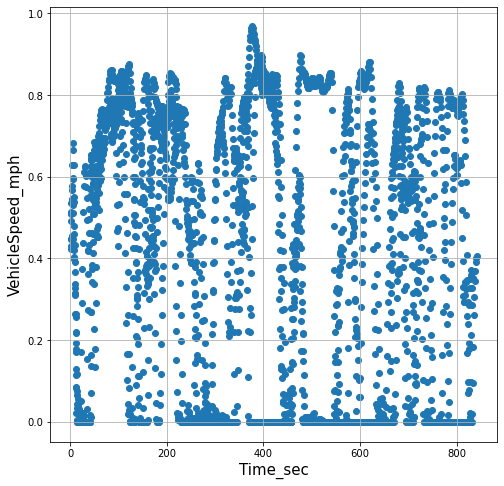

In [69]:
fig = plt.figure(figsize=(8,8))
plt.scatter(x_train[0:,0],x_train[0:,1])
plt.xlabel('Time_sec', fontsize=15)
plt.ylabel('VehicleSpeed_mph', fontsize=15)
plt.grid()

# Random Forest

In [116]:
#prepare the model

from sklearn.ensemble import RandomForestRegressor
from sklearn import metrics
#create an array which will hold samples split to be tested
samples_split = np.array([25, 50, 75, 100, 125, 150, 200, 250, 300, 500])
#create an empty array to hold Mean Abosulte error values
train_MAE = []
test_MAE = []
# For loop to go over different sample split scenarios
for i in range (0,10):
    regressor = RandomForestRegressor(min_samples_split=samples_split[i],random_state = 2)
    regressor.fit(x_train, y_train)
    Predict = regressor.predict(x_train)
    Predict_test = regressor.predict(x_test)
    train_MAE.append(metrics.mean_absolute_error(y_train[:,0], Predict[:,0]))
    test_MAE.append(metrics.mean_absolute_error(y_test[:,0], Predict_test[:,0]))
    #print("Mean Absolute Error:", metrics.mean_absolute_error(y_train[:,0], Predict[:,0]))

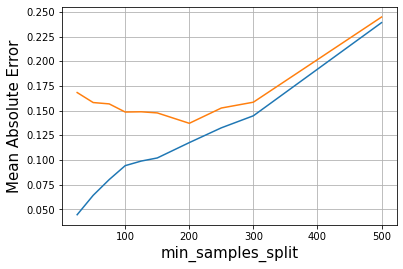

In [117]:
#Comapre the performance of training random forest model for training data set and test data set for predicting velocity
plt.figure(1)
plt.plot(samples_split, train_MAE)
plt.plot(samples_split, test_MAE)
plt.xlabel('min_samples_split', fontsize = 15)
plt.ylabel('Mean Absolute Error', fontsize = 15)
plt.grid()

In [139]:
# From above figure we can see that 200 is optimum min samples split value 
finetuned_regressor = RandomForestRegressor(min_samples_split=200,random_state = 2)
finetuned_regressor.fit(x_train, y_train)
finetuned_predict= finetuned_regressor.predict(x_train)
finetuned_predict_test = finetuned_regressor.predict(x_test)
print("Mean Absolute Error for training data set:", metrics.mean_absolute_error(y_train[:,0], finetuned_predict[:,0]))
print("Mean Absolute Error for test data set:", metrics.mean_absolute_error(y_test[:,0], finetuned_predict_test[:,0]))

Mean Absolute Error for training data set: 0.11772085626155905
Mean Absolute Error for test data set: 0.1372612195890805


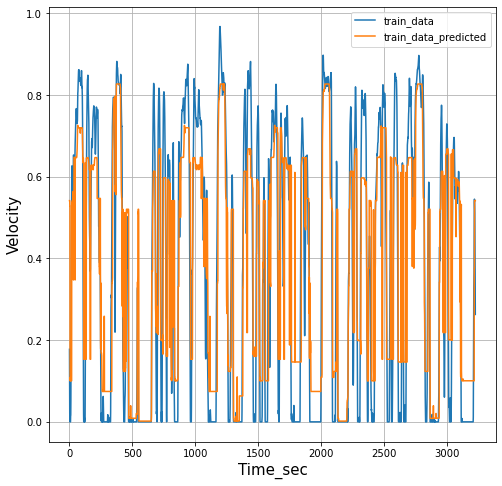

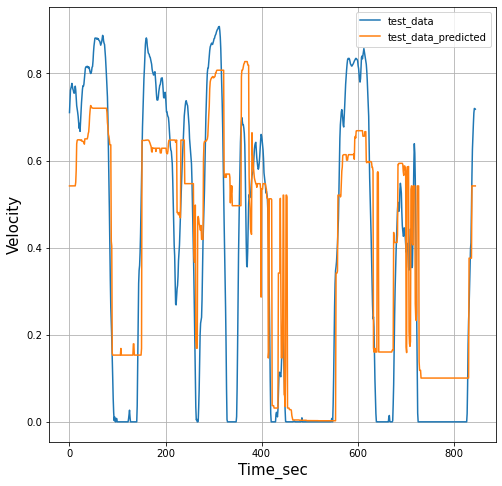

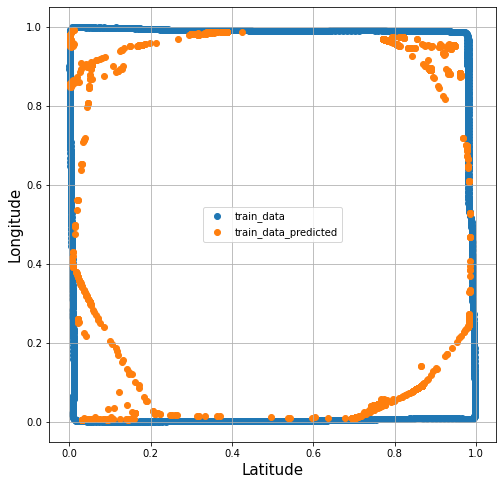

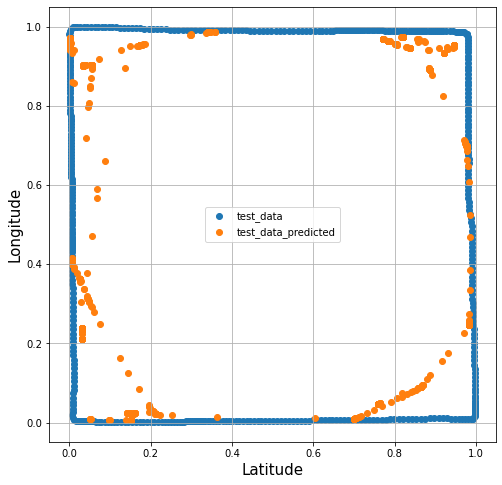

In [140]:
plt.figure(2, figsize=(8,8))
plt.plot(y_train[:,0], label="train_data")
plt.plot(finetuned_predict[:,0], label="train_data_predicted" )
plt.xlabel('Time_sec', fontsize = 15)
plt.ylabel('Velocity', fontsize = 15)
plt.legend()
plt.grid()

plt.figure(3, figsize=(8,8))
plt.plot(y_test[:,0], label="test_data")
plt.plot(finetuned_predict_test[:,0], label="test_data_predicted")
plt.xlabel('Time_sec', fontsize = 15)
plt.ylabel('Velocity', fontsize = 15)
plt.legend()
plt.grid()

plt.figure(4, figsize=(8,8))
plt.scatter(y_train[:,1],y_train[:,2], label="train_data")
plt.scatter(finetuned_predict[:,1], finetuned_predict[:,2] ,label="train_data_predicted")
plt.xlabel('Latitude', fontsize = 15)
plt.ylabel('Longitude', fontsize = 15)
plt.legend()
plt.grid()

plt.figure(5, figsize=(8,8))
plt.scatter(y_test[:,1],y_test[:,2], label="test_data")
plt.scatter(finetuned_predict_test[:,1], finetuned_predict_test[:,2] ,label="test_data_predicted")
plt.xlabel('Latitude', fontsize = 15)
plt.ylabel('Longitude', fontsize = 15)
plt.legend()
plt.grid()